# Library

In [18]:
import sys

sys.path.append("quickstart/code/learn")


In [19]:
import math
from tqdm import tqdm
import cv2
import torch
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage.filters as filters


In [20]:
from quickstart.code.learn.models.unet import ResNetBackbone
from quickstart.code.learn.models.corner_models import CornerEnum
from quickstart.code.learn.density_full import (
    get_density_slices,
    stack_density_slices,
    padding_density_full,
)


# density_full

In [21]:
floor_idx = 11
data_path = "quickstart/data"
floor_name = "32_ShortOffice_05_F2"
floor_name = "S_01_0001_1_I"


In [23]:
density_slices = get_density_slices(data_path, floor_name)
_density_full = stack_density_slices(density_slices)
_density_full = padding_density_full(_density_full)

if floor_name == "32_ShortOffice_05_F2":
    assert _density_full.shape == (1462, 1462, 3)
elif floor_name == "S_01_0001_1_I":
    assert _density_full.shape == (1462, 1462, 3)
    # assert _density_full.shape == (256, 256, 3)


# get_pred_corners

In [24]:
def positional_encoding_2d(d_model, height, width):
    """
    :param d_model: dimension of the model
    :param height: height of the positions
    :param width: width of the positions
    :return: d_model*height*width position matrix
    """
    if d_model % 4 != 0:
        raise ValueError(
            "Cannot use sin/cos positional encoding with "
            "odd dimension (got dim={:d})".format(d_model)
        )
    pe = torch.zeros(d_model, height, width)
    # Each dimension use half of d_model
    d_model = int(d_model / 2)
    div_term = torch.exp(torch.arange(0.0, d_model, 2) * -(math.log(10000.0) / d_model))
    pos_w = torch.arange(0.0, width).unsqueeze(1)
    pos_h = torch.arange(0.0, height).unsqueeze(1)
    pe[0:d_model:2, :, :] = (
        torch.sin(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
    )
    pe[1:d_model:2, :, :] = (
        torch.cos(pos_w * div_term).transpose(0, 1).unsqueeze(1).repeat(1, height, 1)
    )
    pe[d_model::2, :, :] = (
        torch.sin(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
    )
    pe[d_model + 1 :: 2, :, :] = (
        torch.cos(pos_h * div_term).transpose(0, 1).unsqueeze(2).repeat(1, 1, width)
    )

    return pe


In [7]:
def get_pixel_features(image_size, d_pe=128):
    all_pe = positional_encoding_2d(d_pe, image_size, image_size)
    pixels_x = np.arange(0, image_size)
    pixels_y = np.arange(0, image_size)

    xv, yv = np.meshgrid(pixels_x, pixels_y)
    all_pixels = list()
    for i in range(xv.shape[0]):
        pixs = np.stack([xv[i], yv[i]], axis=-1)
        all_pixels.append(pixs)
    pixels = np.stack(all_pixels, axis=0)

    pixel_features = all_pe[:, pixels[:, :, 1], pixels[:, :, 0]]
    pixel_features = pixel_features.permute(1, 2, 0)
    return pixels, pixel_features


In [25]:
def corner_nms(preds, confs, image_shape):
    data = np.zeros(image_shape)
    neighborhood_size = 5
    threshold = 0

    for i in range(len(preds)):
        data[preds[i, 1], preds[i, 0]] = confs[i]

    data_max = filters.maximum_filter(data, neighborhood_size)
    maxima = data == data_max
    data_min = filters.minimum_filter(data, neighborhood_size)
    diff = (data_max - data_min) > threshold
    maxima[diff == 0] = 0

    results = np.where(maxima > 0)
    filtered_preds = np.stack([results[1], results[0]], axis=-1)

    new_confs = list()
    for i, pred in enumerate(filtered_preds):
        new_confs.append(data[pred[1], pred[0]])
    new_confs = np.array(new_confs)

    return filtered_preds, new_confs


In [26]:
corner_model_path = "../../ckpts/corner"


def init_corner_models(ckpt_path="", floor_idx=-1):

    # Load corner backbone
    backbone = ResNetBackbone()
    strides = backbone.strides
    num_channels = backbone.num_channels
    backbone = backbone.cuda()
    backbone.eval()

    # Load corner model
    corner_model = CornerEnum(
        input_dim=128,
        hidden_dim=256,
        num_feature_levels=4,
        backbone_strides=strides,
        backbone_num_channels=num_channels,
    )
    corner_model = corner_model.cuda()
    corner_model.eval()

    if not ckpt_path:
        assert floor_idx > -1
        ckpt_path = f"{corner_model_path}/{floor_idx}/checkpoint.pth"
    ckpt = torch.load(ckpt_path, weights_only=False)

    backbone_ckpt = {}
    for key, value in ckpt["backbone"].items():
        key = key.replace("module.", "")
        backbone_ckpt[key] = value
    backbone.load_state_dict(backbone_ckpt)

    corner_model_ckpt = {}
    for key, value in ckpt["corner_model"].items():
        key = key.replace("module.", "")
        corner_model_ckpt[key] = value
    corner_model.load_state_dict(corner_model_ckpt)

    corner_backbone = backbone
    corner_model = corner_model

    # print("Loaded corner models")

    return corner_backbone, corner_model


In [27]:
density_mean = [0.18115416, 0.18115416, 0.18115416]
density_std = [0.27998772, 0.27998772, 0.27998772]


In [28]:
# hyperparameters
corner_thresh = 0.5
c_padding = 16
side_len = 256 - c_padding * 2
stride = side_len // 4
ignore_border = 16


In [29]:
# pad the image so we get predictions near boundary
density_full = _density_full.copy()

# determine overlapping crops
(h, w, _) = density_full.shape

bboxes = []
for i in range(int(w / stride) + 1):
    for j in range(int(h / stride) + 1):
        minx = i * stride
        miny = j * stride
        maxx = minx + side_len
        maxy = miny + side_len

        if maxy > h:
            miny = h - side_len
            maxy = h

        if maxx > w:
            minx = w - side_len
            maxx = w

        bbox = [minx, miny, maxx, maxy]
        if (not len(bboxes)) or (bboxes[-1] != bbox):
            bboxes.append(bbox)


In [30]:
# for each crop:
# 1. run corner detector
# 2. ignore predictions near the border
# 3. paste onto a full floorplan result

corner_full = np.zeros((h, w), dtype=np.float32)
pixels, pixel_features = get_pixel_features(image_size=256)
pixel_features = pixel_features.unsqueeze(0).cuda()

print("Running corner detector on crops")
for minx, miny, maxx, maxy in tqdm(bboxes):
    density_crop = density_full[miny:maxy, minx:maxx, :].copy()
    density_crop = np.pad(
        density_crop, [[c_padding, c_padding], [c_padding, c_padding], [0, 0]]
    )
    assert density_crop.shape == (256, 256, 3)
    density_crop_512 = density_crop.copy()

    density_crop = density_crop.transpose((2, 0, 1))
    density_crop -= np.array(density_mean)[:, np.newaxis, np.newaxis]
    density_crop /= np.array(density_std)[:, np.newaxis, np.newaxis]
    density_crop = density_crop.astype(np.float32)

    # run corner network
    density_crop = torch.tensor(density_crop).unsqueeze(0).cuda()
    corner_backbone, corner_model = init_corner_models(
        ckpt_path="quickstart/ckpts/corner/11/checkpoint.pth",
        floor_idx=floor_idx,
    )
    with torch.no_grad():
        image_feats, feat_mask, all_image_feats = corner_backbone(
            density_crop
        )  # self.corner_backbone
        _corner_crop = corner_model(  # self.corner_model
            image_feats, feat_mask, pixel_features, pixels, all_image_feats
        )
    corner_crop = _corner_crop[0].detach().cpu().numpy()
    corner_crop = corner_crop[c_padding:-c_padding, c_padding:-c_padding]

    keep_mask = np.zeros_like(corner_crop, dtype=bool)
    keep_mask[ignore_border:-ignore_border, ignore_border:-ignore_border] = True
    corner_crop[~keep_mask] = 0

    # paste prediction in full view
    corner_full[miny:maxy, minx:maxx] = np.maximum(
        corner_full[miny:maxy, minx:maxx], corner_crop
    )


Running corner detector on crops


100%|██████████| 648/648 [10:21<00:00,  1.04it/s]


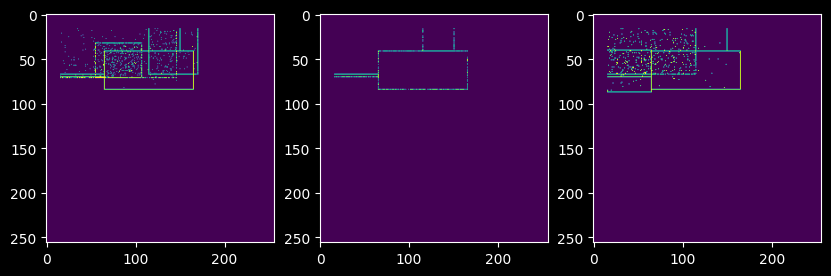

In [32]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))
for i in range(3):
    ax = axes[i]
    ax.imshow(
        density_crop.detach()
        .cpu()
        .numpy()
        .astype(int)
        .squeeze()
        .transpose((1, 2, 0))[:, :, i]
    )


In [33]:
_ = [print(image_feats[f"{i}"].shape) for i in range(3)]
feat_mask.shape
# all_image_feats.keys()  # dict_keys(['layer0', 'layer1', 'layer2', 'layer3', 'layer4', 'x_original'])


torch.Size([1, 512, 32, 32])
torch.Size([1, 1024, 16, 16])
torch.Size([1, 2048, 8, 8])


torch.Size([1, 256, 256])

In [34]:
feat_mask_np = feat_mask.detach().cpu().numpy().squeeze()
sum(feat_mask_np)


array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

In [35]:
# run NMS to obtain corners in this floorplan
(height, width) = corner_full.shape
pixels_x = np.arange(0, width)
pixels_y = np.arange(0, height)

xv, yv = np.meshgrid(pixels_x, pixels_y)
all_pixels = list()
for i in range(xv.shape[0]):
    pixs = np.stack([xv[i], yv[i]], axis=-1)
    all_pixels.append(pixs)
pixels_full = np.stack(all_pixels, axis=0)

pos_indices = np.where(corner_full >= corner_thresh)
pred_corners = pixels_full[pos_indices]
pred_confs = corner_full[pos_indices]
pred_corners, pred_confs = corner_nms(  # my_utils.corner_nms
    pred_corners, pred_confs, image_shape=corner_full.shape
)
print(len(pred_corners))


7


In [37]:
np.save(f"quickstart/data/pred_corners/{floor_name}.npy", pred_corners)


In [18]:
# remove padding from pixel coordinates
# density_full = density_full[pad_border:-pad_border, pad_border:-pad_border]
# corner_full = corner_full[pad_border:-pad_border, pad_border:-pad_border]
# pred_corners -= pad_border


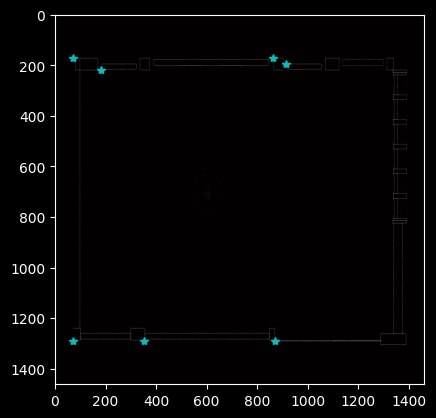

In [36]:
plt.imshow(density_full[:, :, 1], cmap="gray")
plt.imshow(
    corner_full,
    cmap="hot",
    alpha=0.3,
)
plt.plot(pred_corners[:, 0], pred_corners[:, 1], "*c")
plt.show()
plt.close()
